# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import numpy.polynomial.legendre as npl

from scipy.optimize import minimize, fmin_l_bfgs_b, fmin_slsqp

### Notebook settings

In [12]:
%matplotlib notebook

## Create Synthetic Data

<IPython.core.display.Javascript object>


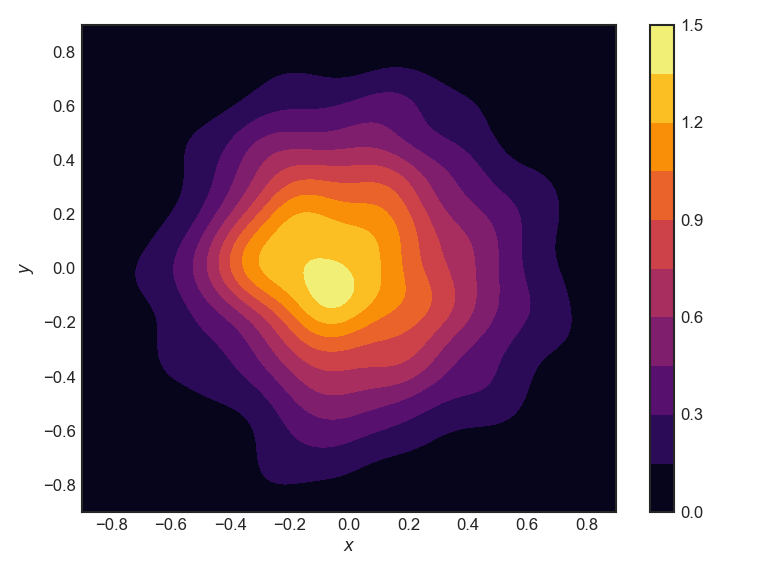

In [11]:
N = 600

x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)), size=N).T
#x = np.random.uniform(low=-0.9, high=0.9, size=N)
#y = np.random.uniform(low=-0.9, high=0.9, size=N)

fig, ax = plt.subplots()
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=ax, cmap='inferno', cbar=True)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Maximum Likelihood Estimate of the Density
### Initialize Legendre polynomials
Choose polynomial degrees $I$ and $J$, initialize coefficients $\mathbf{c}$, and compute basis-function values at all values of $x$ and $y$.

In [13]:
I = 20
J = 20

#c = np.random.uniform(low=-0.1, high=0.1, size=(I+1)*(J+1))
#c /= c.dot(c)
c = np.zeros((I+1)*(J+1))
c[0] = 1
c = np.append(N, c)
#x= 0.5
#y = 0.5

norm = np.array([[np.sqrt(2/(2*i + 1))*np.sqrt(2/(2*j + 1)) for j in range(J+1)] for i in range(I+1)])
phi_ijn = npl.legvander2d(x, y, (I, J)).T / norm.ravel()[:, np.newaxis]

### Likelihood and constraint

In [14]:
def neglogl(c):
    return -np.log(np.square(c.dot(phi_ijn))).sum()

def grad_neglogl(c):
    return -2*(phi_ijn / c.dot(phi_ijn)).sum(axis=1)

def normalization(c):
    return c.dot(c) - 1

def grad_normalization(c):
    return 2*c

constraint = {'type': 'eq',
              'fun': normalization,
              'jac': grad_normalization}

option = {'maxiter': 5000}

### Compound objective function

In [15]:
grad_c = np.zeros_like(c)

def objective(c):
    return -1*np.log(np.square(c[1:].dot(phi_ijn))).sum() + c[0]*(c[1:].dot(c[1:]) - 1)

def grad_objective(c):
    grad_c[0] = c[1:].dot(c[1:]) - 1
    grad_c[1:] = -2*(phi_ijn / c[1:].dot(phi_ijn)).sum(axis=1) + 2*c[0]*c[1:]
    return grad_c

### Direct optimization of compound objective function

In [16]:
#%%timeit -n 100 -r 10
res_direct = minimize(objective, c, method='l-bfgs-b', jac=grad_objective)
#res_direct.x[1:].dot(res_direct.x[1:])

### Contrained minimization of negative log-likelihood

In [17]:
#%%timeit #-n 10 -r 10
res_constrained = minimize(neglogl, c[1:], method='slsqp', jac=grad_neglogl, constraints=constraint, options=option)
#res_constrained.x.dot(res_constrained.x)

In [11]:
#%%timeit #-n 10 -r 10
x = fmin_slsqp(neglogl, c[1:], 
               eqcons=(normalization,),
               fprime=grad_neglogl,
               fprime_eqcons=grad_normalization,
               iter=5000,
               disp=False)

In [ ]:
%%timeit -n 100 -r 10
x, value, status = fmin_l_bfgs_b(objective, c, grad_objective)

### Plot comparative results
The estimated density is evaluated on a uniform grid.

<IPython.core.display.Javascript object>


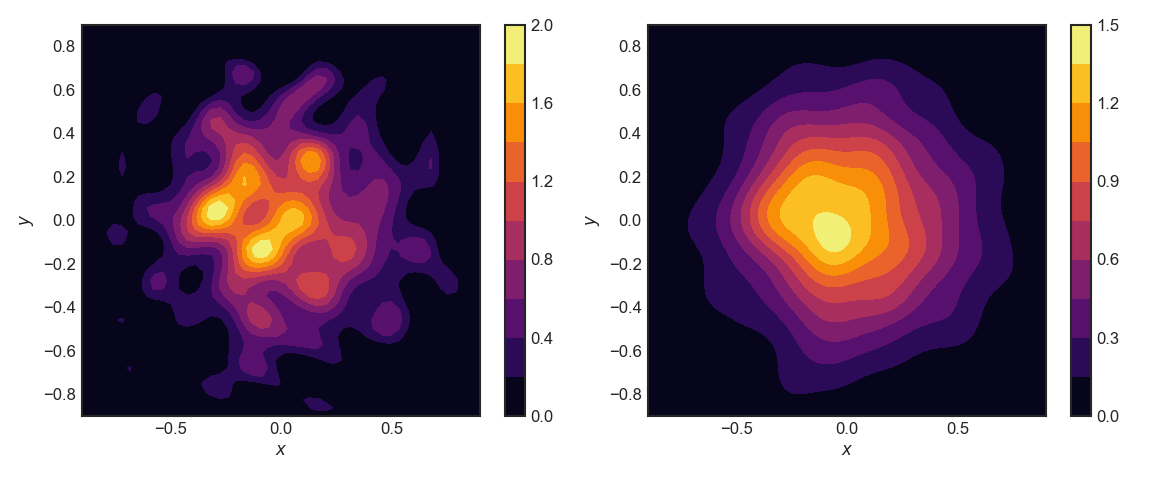

In [18]:
x_grid = np.linspace(-0.9, 0.90, 50)
y_grid = np.linspace(-0.9, 0.90, 50)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
p = np.square(npl.legval2d(x_grid, y_grid, res_direct.x[1:].reshape((I+1, J+1))/norm))

fig, (lax, kax) = plt.subplots(1, 2, figsize=(9.7, 4))
lax.set(xlabel=r'$x$', ylabel=r'$y$')
contour = lax.contourf(x_grid, y_grid, p, 9, cmap='inferno')
cbar = plt.colorbar(contour, ax=lax)
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=kax, cmap='inferno', cbar=True)
kax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Density Gradient

<IPython.core.display.Javascript object>


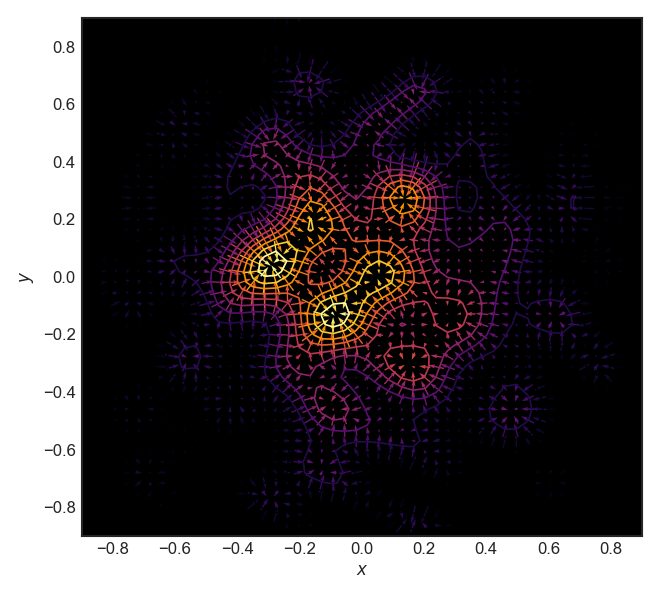

In [19]:
coeffs_of_grad_x = npl.legder(res_direct.x[1:].reshape((I+1, J+1))/norm, axis=0)
coeffs_of_grad_y = npl.legder(res_direct.x[1:].reshape((I+1, J+1))/norm, axis=1)

grad_x = 2*(npl.legval2d(x_grid, y_grid, res_direct.x[1:].reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_x))
grad_y = 2*(npl.legval2d(x_grid, y_grid, res_direct.x[1:].reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_y))

fig, ax = plt.subplots(figsize=(5.5, 5),)
ax.quiver(x_grid, y_grid, grad_x, grad_y, p, angles='xy', pivot='middle', cmap='inferno')
ax.contour(x_grid, y_grid, p, 9, cmap='inferno', linewidths=1.0)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9), facecolor='k')
fig.tight_layout()